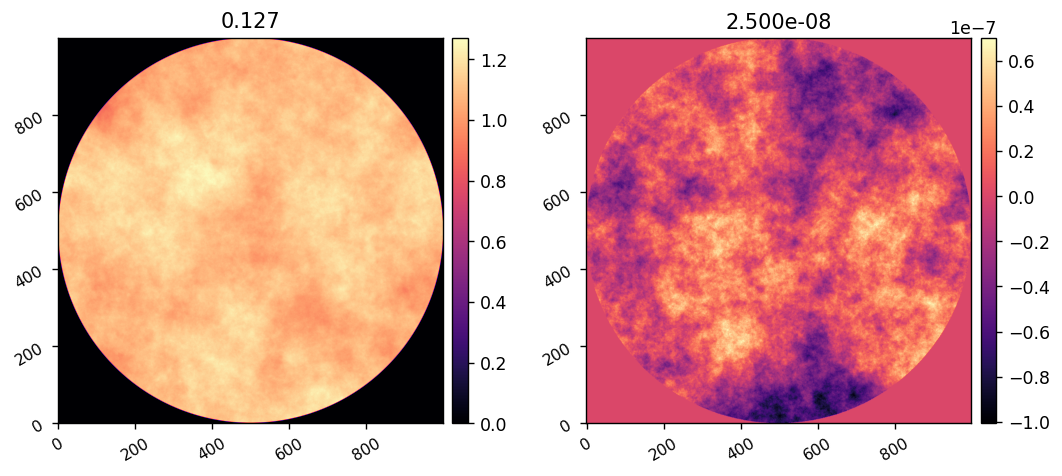

array(2.5e-08)

In [31]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from IPython.display import clear_output

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])


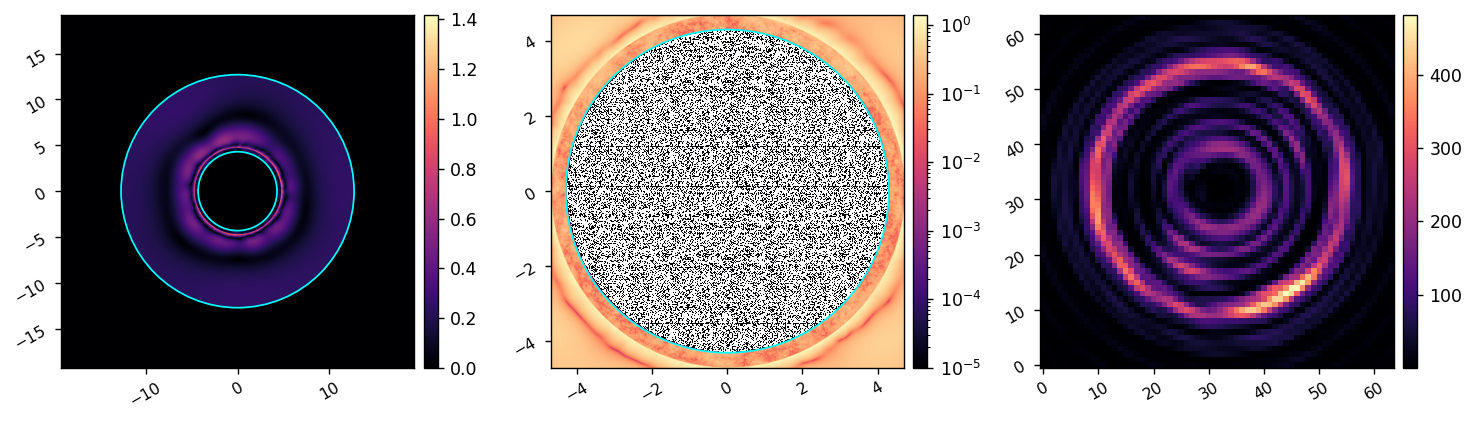

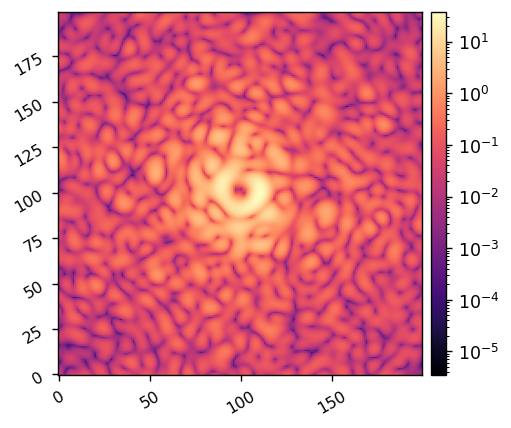

In [2]:
model = cscoob.CORO()
model.WFE = WFE
model.use_fpm = True
model.use_llowfsc()
model.llowfsc_fl = 200*u.mm

wfs = model.calc_wfs()
llowfsc_im = xp.abs(wfs[-1])**2

# imshow1(im)
imshow3(xp.abs(wfs[-2]), xp.abs(wfs[-2]), llowfsc_im, npix2=model.npix, lognorm2=True, vmin2=1e-5, 
        pxscl1=model.lyot_pupil_diam/model.npix, pxscl2=model.lyot_pupil_diam/model.npix,
        patches1=[Circle((0,0), 8.6/2, fill=False, color='cyan'),
                  Circle((0,0), 25.4/2, fill=False, color='cyan'),],
        patches2=[Circle((0,0), 8.6/2, fill=False, color='cyan'),],
                  )

model.use_llowfsc(False)
coro_im = model.snap()
imshow1(coro_im, lognorm=True)

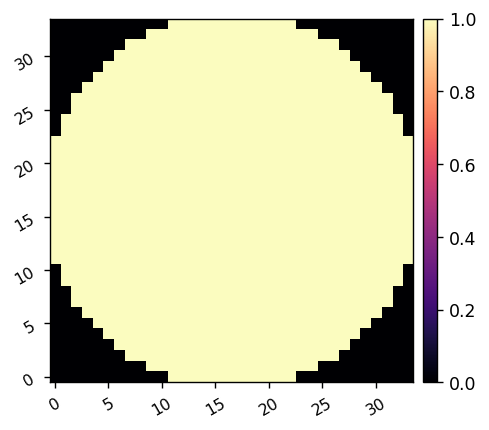

array(952)

In [3]:
dm_mask = xp.ones((model.Nact,model.Nact), dtype=bool)
xx = (xp.linspace(0, model.Nact-1, model.Nact) - model.Nact/2 + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(model.Nact+1)/2] = 0
imshow1(dm_mask)
dm_mask.sum()

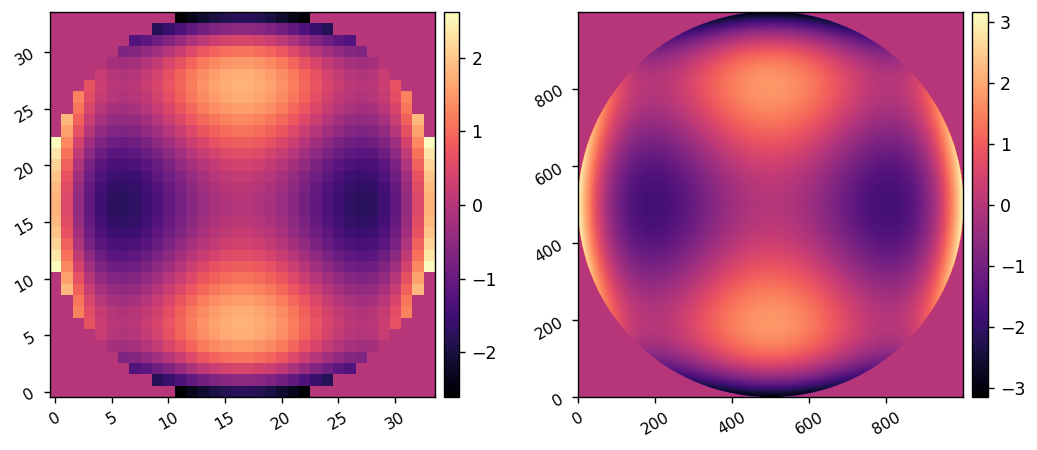

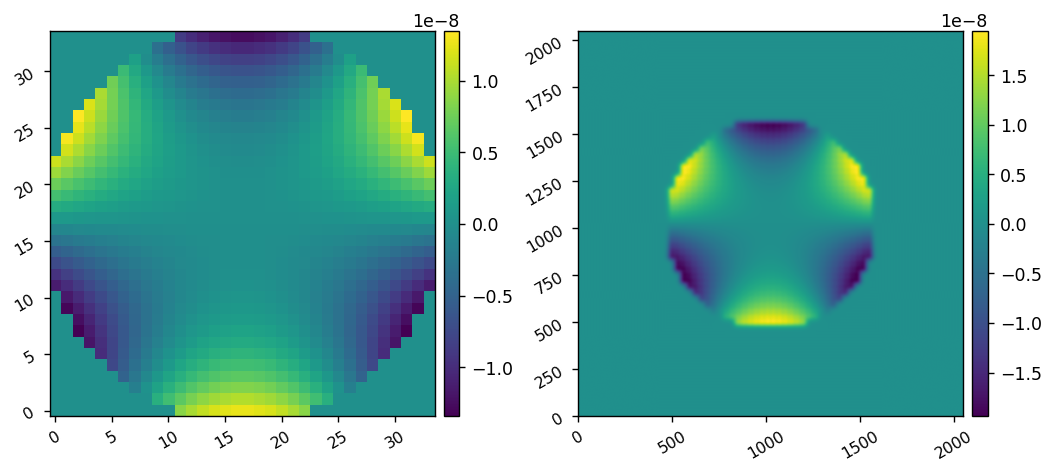

In [9]:
Nmodes = 25
dm_modes = lina.utils.create_zernike_modes(dm_mask, nmodes=Nmodes, remove_modes=1)
wfe_modes = lina.utils.create_zernike_modes(model.APERTURE, nmodes=Nmodes, remove_modes=1)

i = 10
imshow2(dm_modes[i], wfe_modes[i])

model.set_dm(dm_zernikes[7]*5e-9)
imshow2(dm_zernikes[7]*5e-9, model.DM.get_surface(), cmap1='viridis', cmap2='viridis')
model.reset_dm()


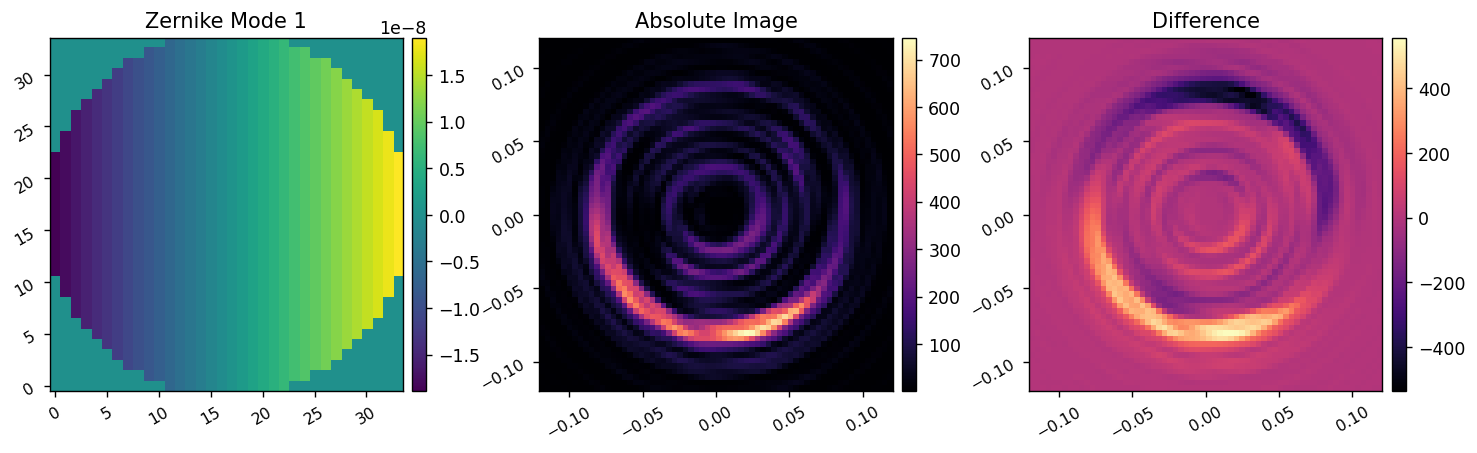

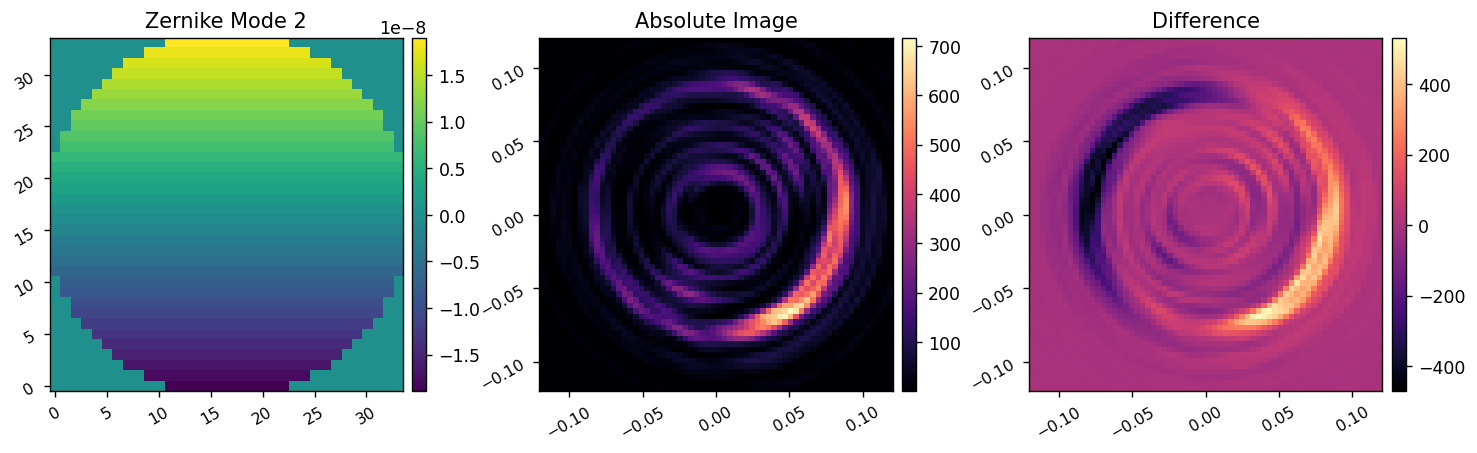

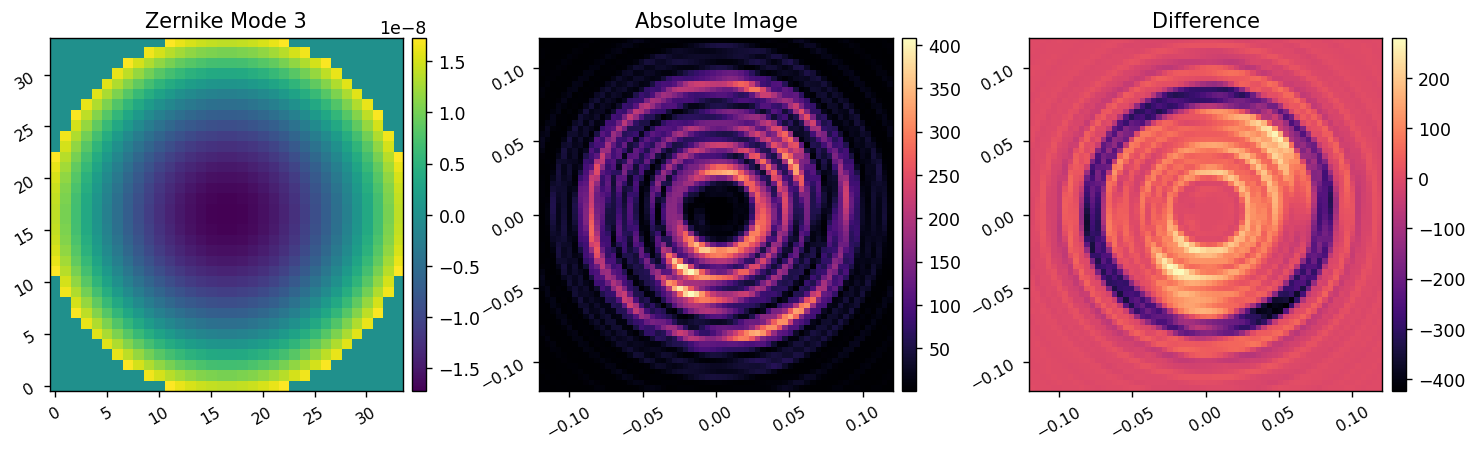

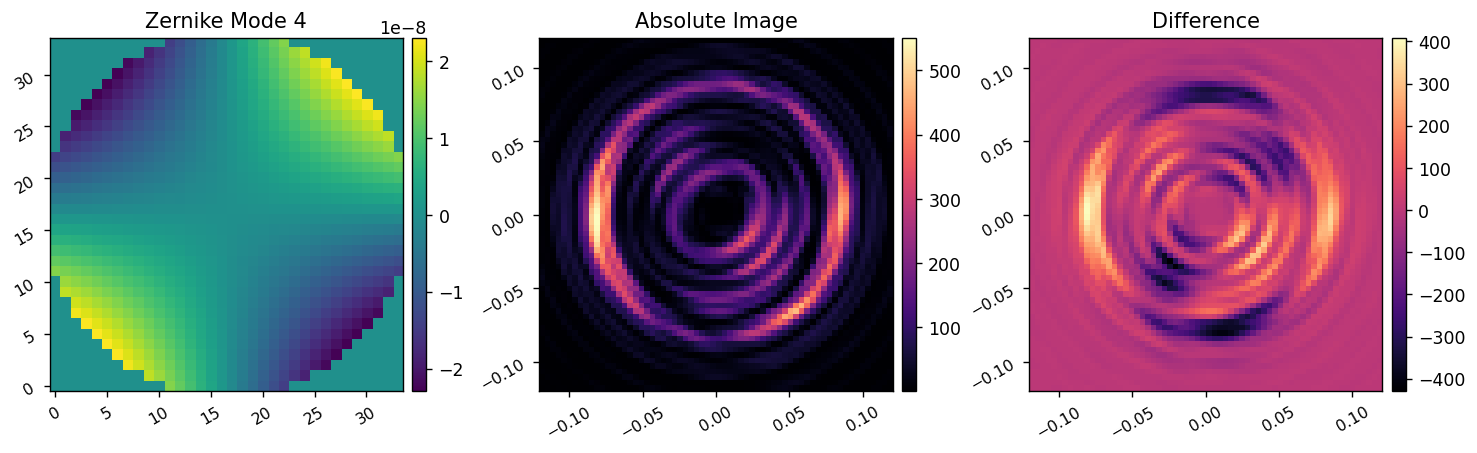

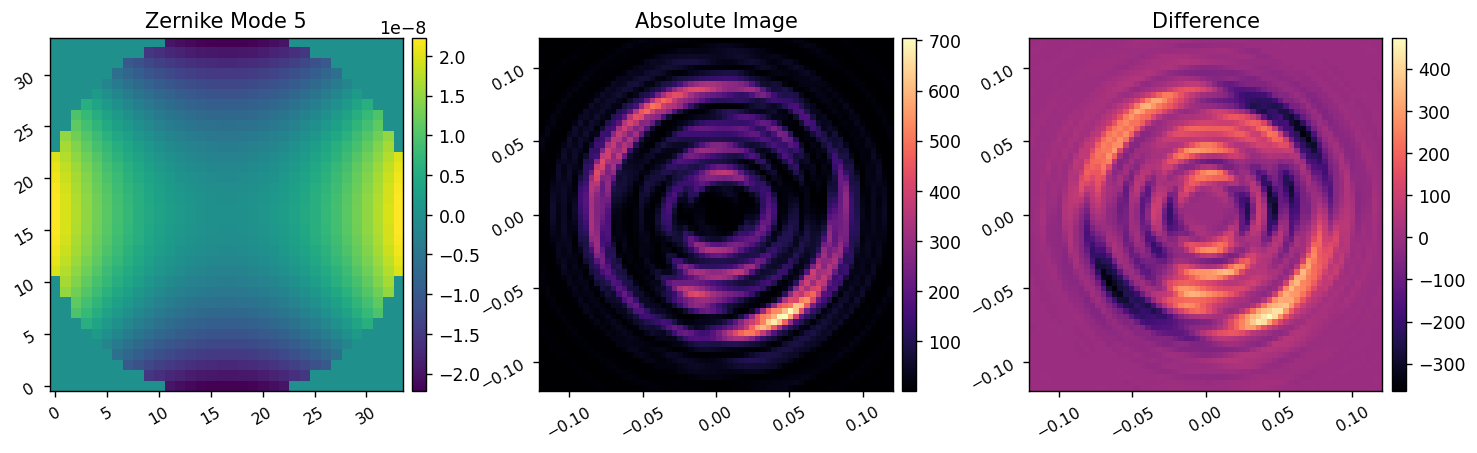

In [13]:
amp = 10e-9

model.use_llowfsc()

model.reset_dm()
model.WFE = WFE

im_ref = model.snap()

responses = xp.zeros((Nmodes, model.nllowfsc**2))
for i in range(Nmodes):
    mode = dm_zernikes[i]

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)
    
    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    if i < 5:
        imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+1}', 'Absolute Image', 'Difference', 
                pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix), 
                cmap1='viridis')

response_matrix = responses.T

In [34]:
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-15)

In [11]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)
s.max()/s.min()

array(1.10602814)

In [36]:
import copy

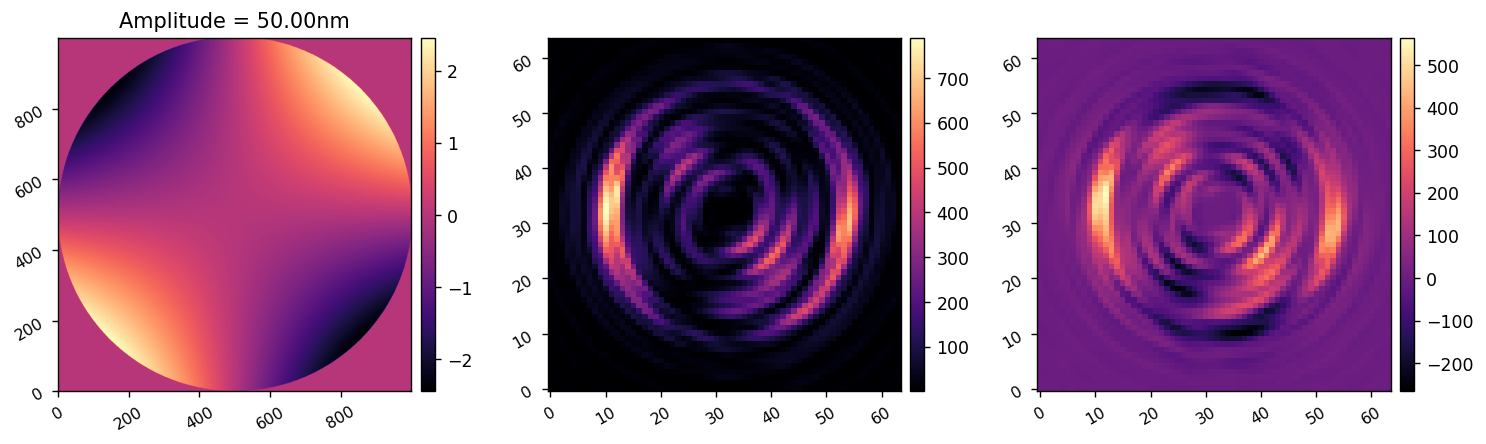

In [70]:
i = 1
Namps = 21
wfe_amps = np.linspace(-50e-9, 50e-9, Namps)

coeff = xp.zeros((Nmodes, Namps, Nmodes))
for i in range(Nmodes):
    for j in range(Namps):
        amp = wfe_amps[j]
        new_wfe = WFE * xp.exp(1j*2*np.pi * amp * wfe_modes[i]/(model.wavelength_c.to_value(u.m)))
        model.WFE = new_wfe
        llowfsc_im = model.snap()
        del_im = llowfsc_im - im_ref
        modal_coeff = control_matrix.dot(del_im.flatten())
        coeff[i,j,:] = copy.copy(modal_coeff)
        imshow3(wfe_modes[i], llowfsc_im, del_im, f'Amplitude = {amp*1e9:.2f}nm')
        clear_output(wait=True)
    if i>2:
        break

In [42]:
modal_coeff

array([-6.26850129e-10,  1.02253886e-08,  9.60436925e-09, -1.55472035e-09,
        9.57026737e-10,  2.26337240e-08,  4.80341869e-10, -1.88915724e-09,
       -1.85031333e-09,  1.06860720e-08, -6.19940656e-10, -2.33379539e-09,
       -1.55559178e-09,  6.47693720e-10,  1.25678124e-09,  1.61720812e-09,
       -2.80530882e-09, -1.34016719e-09, -3.21360893e-10,  9.56810182e-11,
        4.38466033e-09, -4.58009137e-11,  2.26411011e-09,  4.74293111e-11,
       -7.80809257e-10])

In [72]:
coeff[0]

array([[-1.51373517e-08,  6.29229262e-11, -3.16068207e-09,
        -9.33084890e-09, -3.90475231e-09,  3.43204404e-10,
         1.05237882e-09, -5.85671300e-10, -7.71234320e-10,
         1.66455299e-09, -9.05720944e-10, -4.09327836e-09,
        -1.70560400e-11,  2.63004709e-10,  5.16072732e-10,
        -9.72611741e-11, -1.64602765e-09, -4.77602746e-10,
        -6.41681608e-11, -1.34520179e-09,  1.06279158e-09,
        -3.56216856e-09, -2.94130755e-09, -4.52589983e-10,
        -2.01231589e-10],
       [-1.37628942e-08,  1.41814564e-10, -2.80163374e-09,
        -7.59840898e-09, -3.11456947e-09,  3.01708414e-10,
         1.06526129e-09, -4.44098258e-10, -8.60519183e-10,
         1.31140988e-09, -6.00346470e-10, -3.37615904e-09,
         2.84830331e-11,  3.04876878e-10,  4.50163135e-10,
        -1.61042693e-10, -1.37949321e-09, -4.46090172e-10,
        -4.67629465e-11, -1.11090630e-09,  7.94703819e-10,
        -2.79686236e-09, -2.37022006e-09, -2.43458114e-10,
        -1.23405396e-10],
    

In [48]:
import matplotlib.pyplot as plt

Text(0.5, 0.9, 'Measured Response for each Zernike mode')

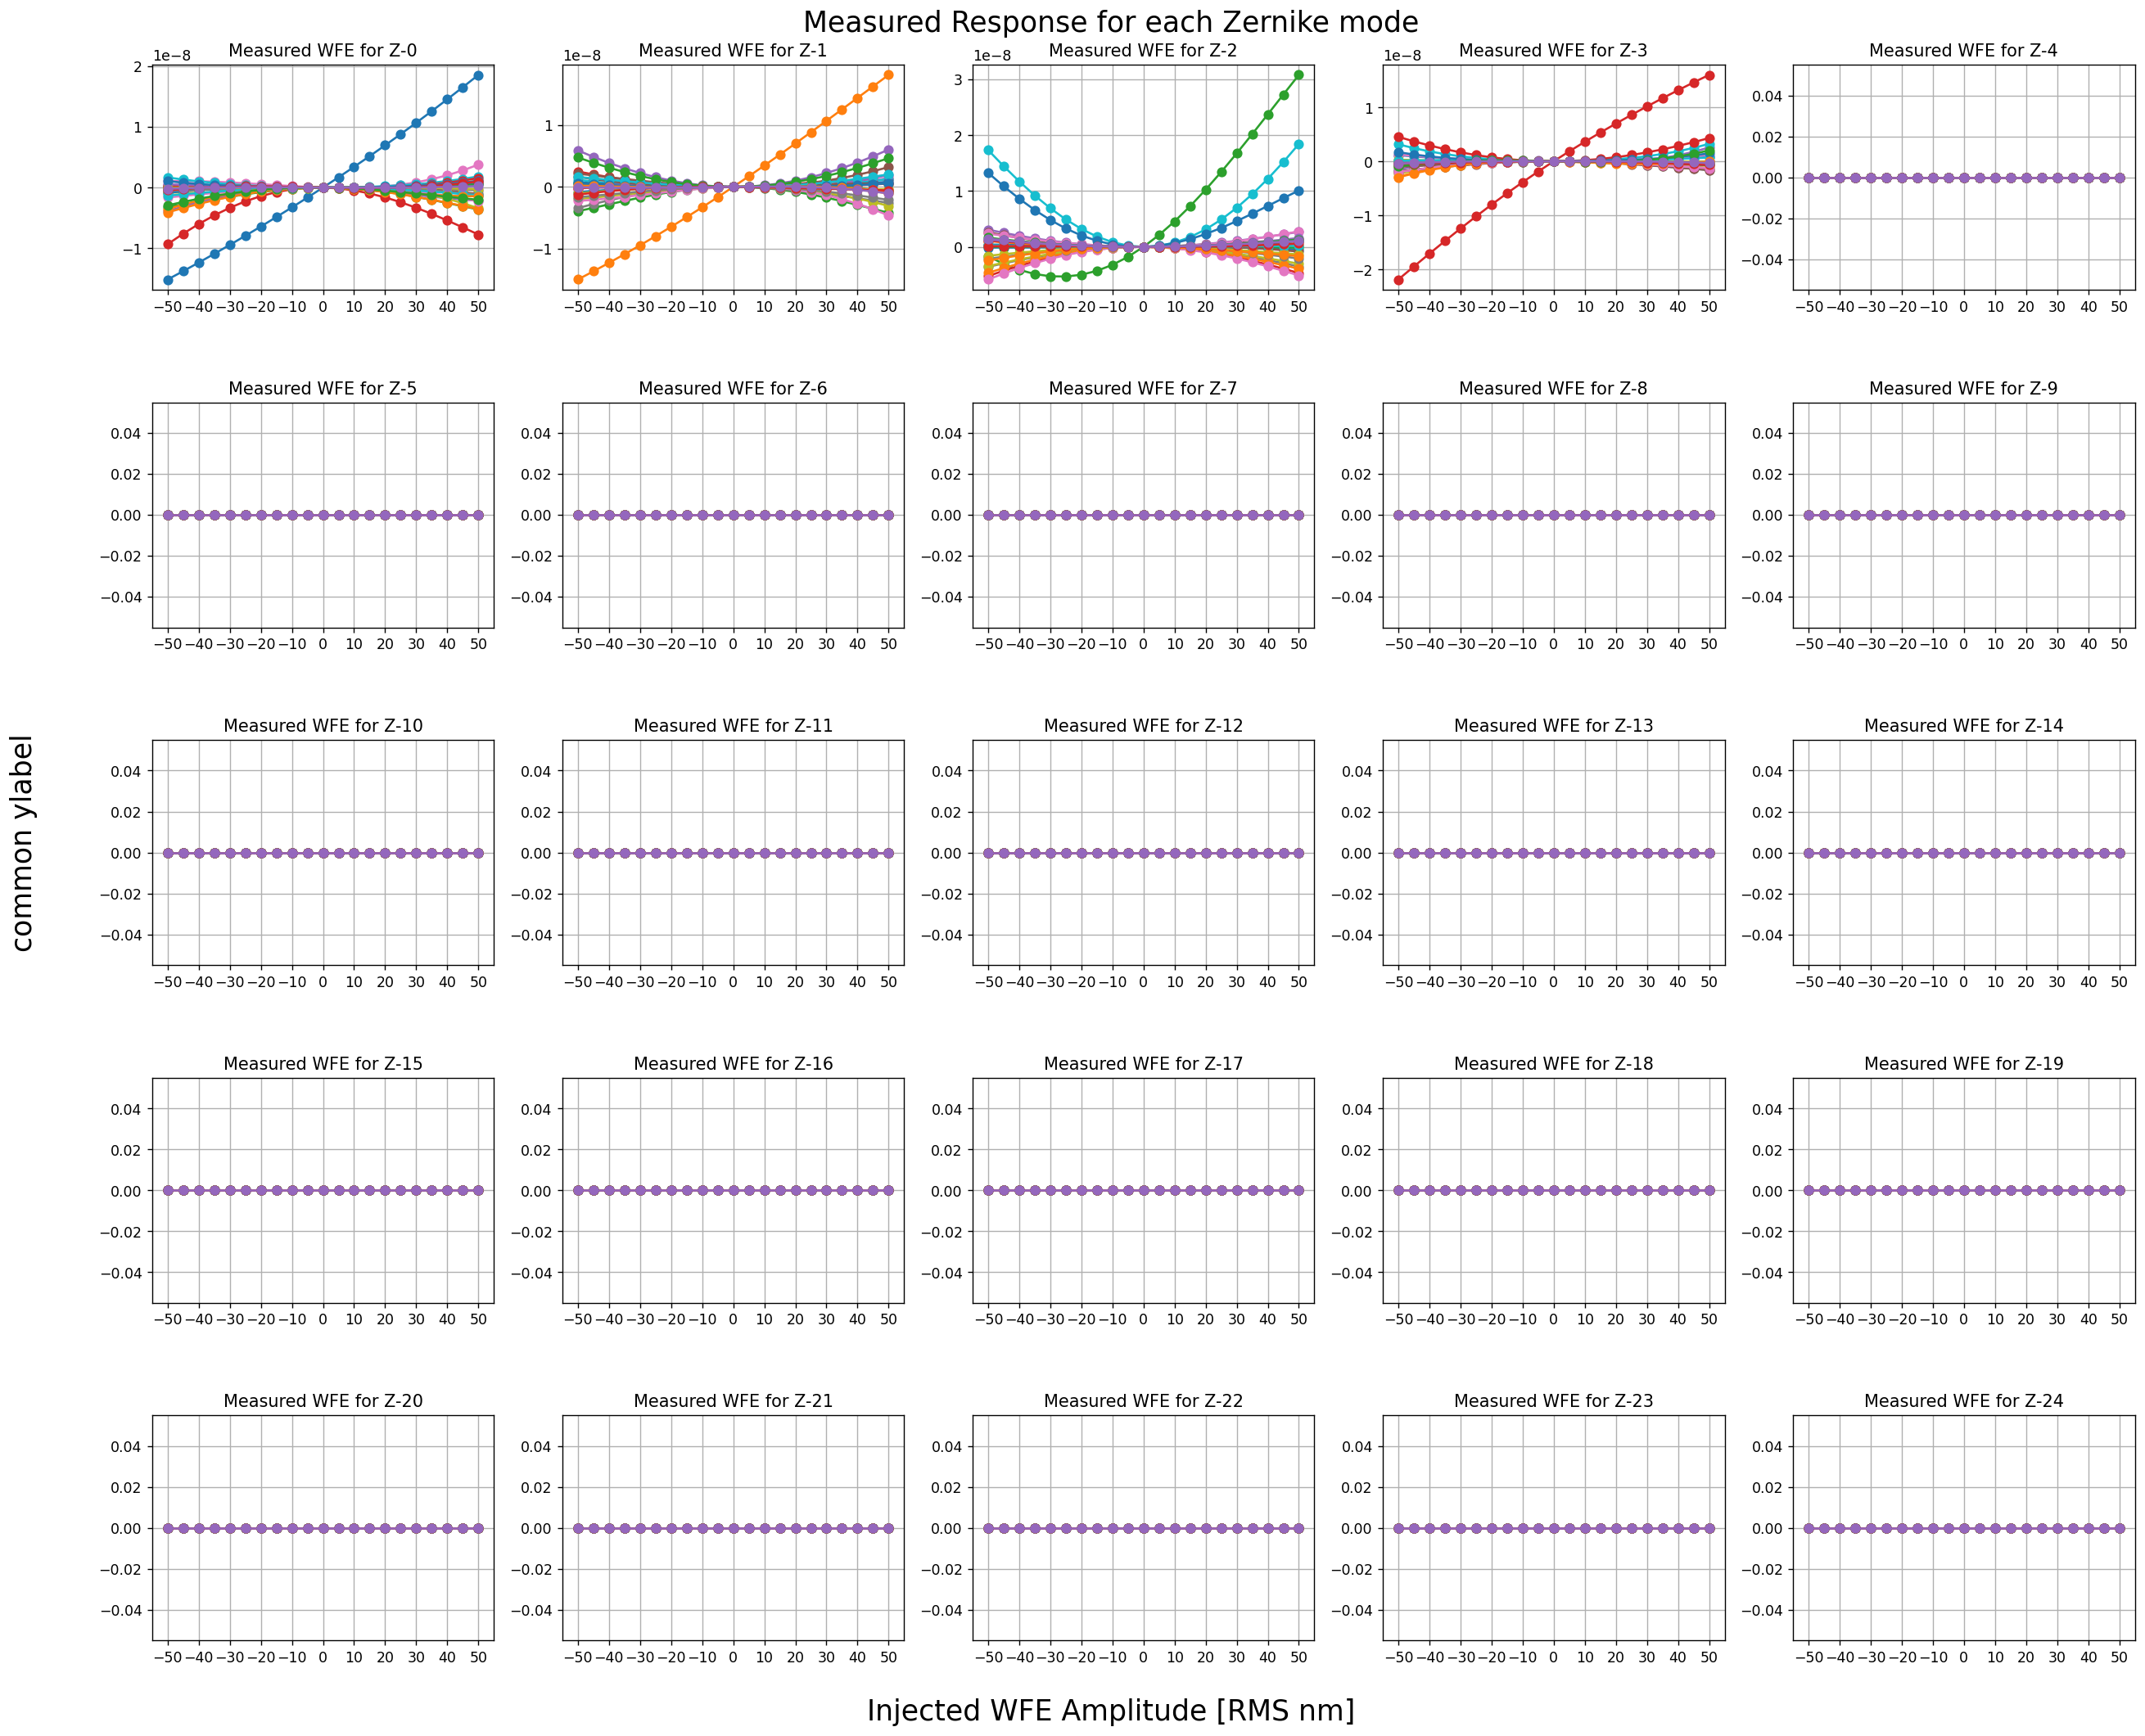

In [88]:

fig, ax = plt.subplots(5,5, figsize=(25,20), dpi=125)
j = 1

for i in range(Nmodes):
    ax_ind = [int(np.floor(i/5)), i%5]
    for j in range(Nmodes):
        ax[ax_ind[0], ax_ind[1]].plot(wfe_amps*1e9, ensure_np_array(coeff[i,:,j]), '-o', label=f'Z-{i+1:d}')
    ax[ax_ind[0], ax_ind[1]].set_title(f'Measured WFE for Z-{i:d}')
    ax[ax_ind[0], ax_ind[1]].set_xticks(wfe_amps[::2]*1e9)
    # ax[ax_ind[0], ax_ind[1]].set_xlabel('Injected WFE Amplitude [RMS nm]')
    # ax.set_ylabel('Computed WFE Amplitude [RMS nm]')
    ax[ax_ind[0], ax_ind[1]].grid()
# ax.legend(bbox_to_anchor=[1.2, 1.1])
plt.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.075, 'Injected WFE Amplitude [RMS nm]', fontsize=20, ha='center', va='center')
fig.text(0.085, 0.5, 'common ylabel', ha='center', va='center', fontsize=20, rotation='vertical')
fig.text(0.5, 0.9, 'Measured Response for each Zernike mode', fontsize=20, ha='center', va='center')


In [77]:
int(np.floor(5/5)), 5%5

(1, 0)